In [1]:
import h5py
import os
import pandas as pd
import numpy as np
from statistics import mode
from vae import Vae
import tensorflow as tf
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from PIL import Image, ImageEnhance

In [2]:
numeral = 'vi'

In [3]:
with h5py.File('./image_data_{}.h5'.format(numeral), 'r') as f:
    images = f['images'][...].astype(np.float32) / 255
    images = np.expand_dims(images, 3)
    labels = f['labels'][...].astype(np.float32)
    
images.shape, labels.shape

((794, 32, 32, 1), (794, 10))

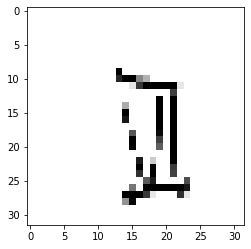

In [4]:
plt.imshow(images[2, :, :, 0], cmap='binary_r')

In [5]:
images.min(), images.max()

(0.0, 1.0)

In [6]:
vae = Vae(images, latent_dim=4, learning_rate=1e-3, standardize_data=False, kl_weight=1.5, validation_split=0.05)

In [7]:
vae.encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 64)        18496     
_________________________________________________________________
flatten (Flatten)            (None, 43264)             0         
_________________________________________________________________
dense (Dense)                (None, 8)                 346120    
Total params: 369,416
Trainable params: 369,416
Non-trainable params: 0
_________________________________________________________________


In [8]:
vae.decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10816)             54080     
_________________________________________________________________
reshape (Reshape)            (None, 26, 26, 16)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 28, 28, 64)        9280      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 30, 30, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 32, 32, 16)        4624      
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 32, 32, 1)         145       
Total params: 86,593
Trainable params: 86,593
Non-trainable params: 0
__________________________________________________

In [9]:
vae._mean, vae._std, vae.train_x.shape, vae.val_x.shape

(0, 1, (755, 32, 32, 1), (39, 32, 32, 1))

In [10]:
len(images) / 8

99.25

In [11]:
vae.train(n_epoch=100, n_batch=8)

Epoch #0, train loss: 528.297, validation loss: 519.746
Epoch #1, train loss: 301.955, validation loss: 307.952
Epoch #2, train loss: 252.808, validation loss: 268.758
Epoch #3, train loss: 222.659, validation loss: 235.279
Epoch #4, train loss: 201.783, validation loss: 213.483
Epoch #5, train loss: 191.321, validation loss: 201.830
Epoch #6, train loss: 185.016, validation loss: 195.106
Epoch #7, train loss: 181.808, validation loss: 191.777
Epoch #8, train loss: 178.243, validation loss: 187.988
Epoch #9, train loss: 176.365, validation loss: 185.529
Epoch #10, train loss: 173.366, validation loss: 183.403
Epoch #11, train loss: 171.072, validation loss: 178.828
Epoch #12, train loss: 165.260, validation loss: 173.548
Epoch #13, train loss: 161.189, validation loss: 171.646
Epoch #14, train loss: 157.882, validation loss: 167.365
Epoch #15, train loss: 156.402, validation loss: 167.279
Epoch #16, train loss: 153.425, validation loss: 162.557
Epoch #17, train loss: 151.920, validatio

In [12]:
vae.train_history.tail()

,train_loss,train_rec_loss,train_kl_loss,val_loss,val_rec_loss,val_kl_loss
95,104.041885,-90.383194,-9.105795,148.254349,-134.773788,-8.987042
96,103.487488,-88.979736,-9.671828,148.631531,-134.069565,-9.707980
97,103.714394,-90.025215,-9.126118,146.223541,-132.893936,-8.886396
98,103.401833,-88.594536,-9.871527,152.416534,-137.300583,-10.077303
99,101.997986,-87.759468,-9.492339,150.238937,-135.427795,-9.874092


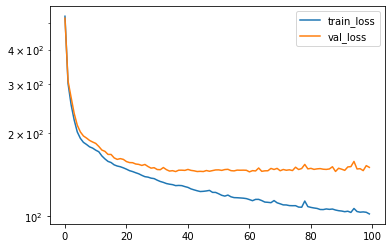

In [13]:
vae.train_history[['train_loss', 'val_loss']].plot()
plt.yscale('log')

In [14]:
vae.save('./vae_{}.zip'.format(numeral))
loaded = Vae.load(images, './vae_{}.zip'.format(numeral))

INFO:tensorflow:Assets written to: /tmp/tmpn2w9vq_m/encoder_model/assets
INFO:tensorflow:Assets written to: /tmp/tmpn2w9vq_m/decoder_model/assets


# Train Images

In [15]:
z = vae.encode(vae.train_x)[0].numpy()
out = vae.decode(z, standardize=False, numpy=False, apply_sigmoid=True, to_image=True)

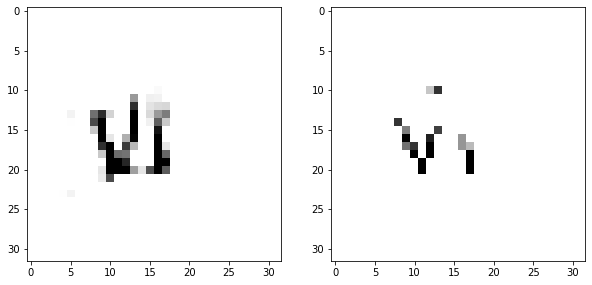

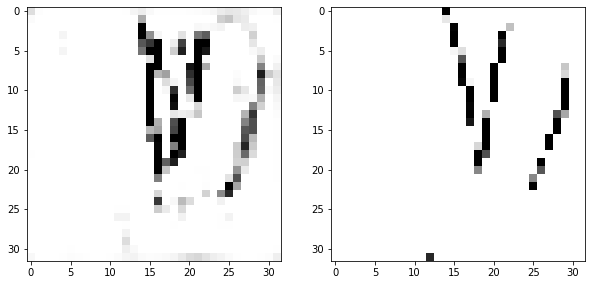

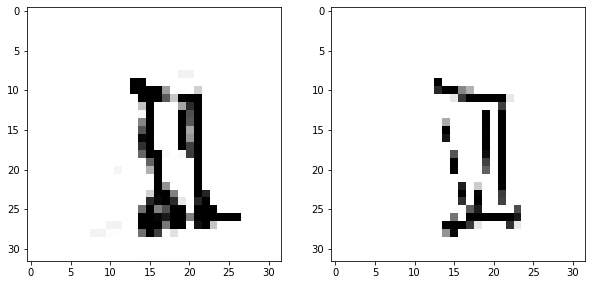

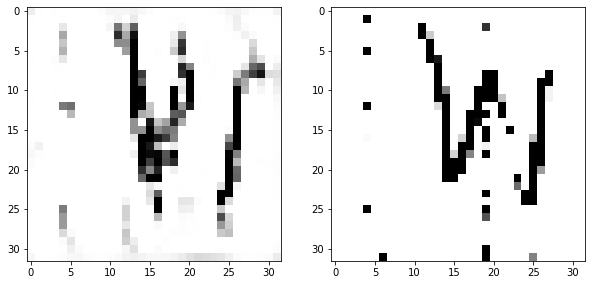

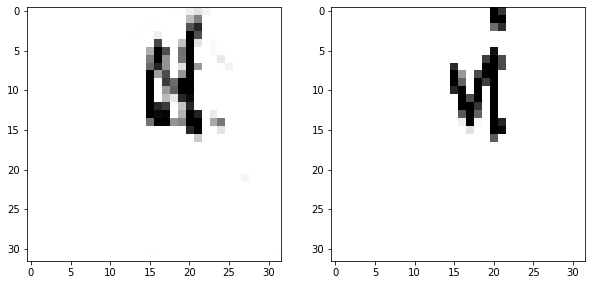

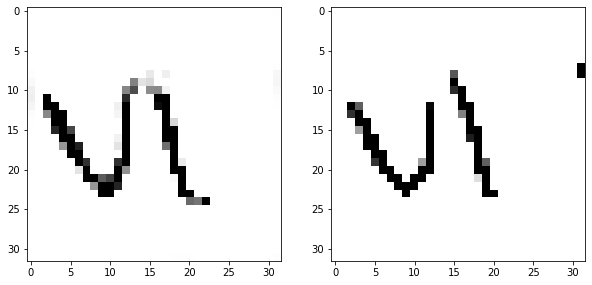

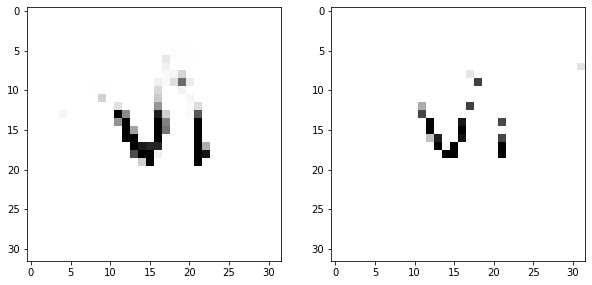

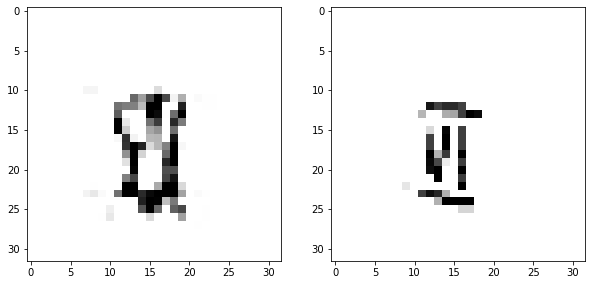

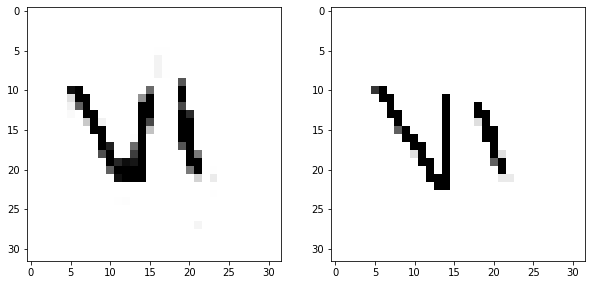

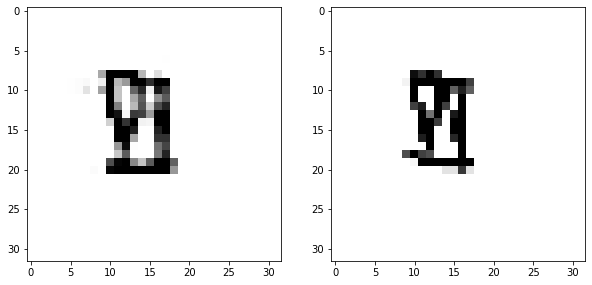

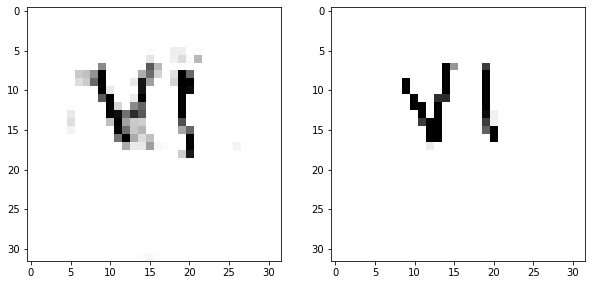

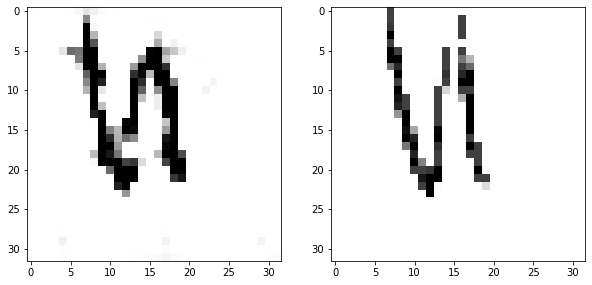

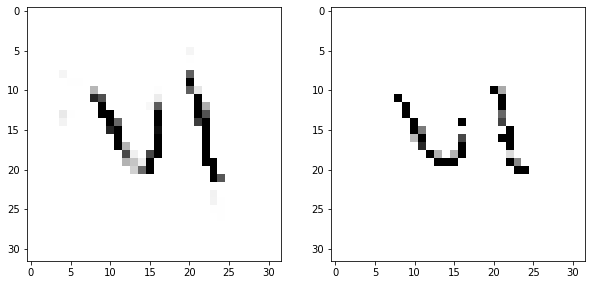

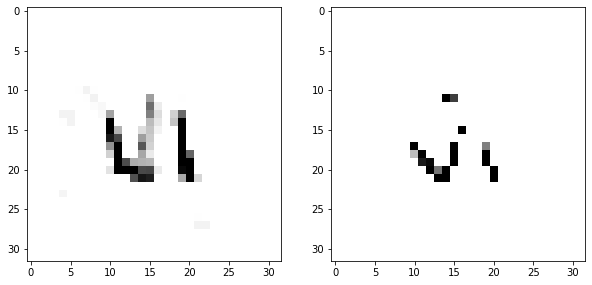

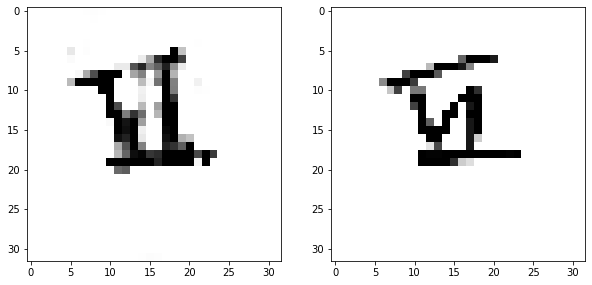

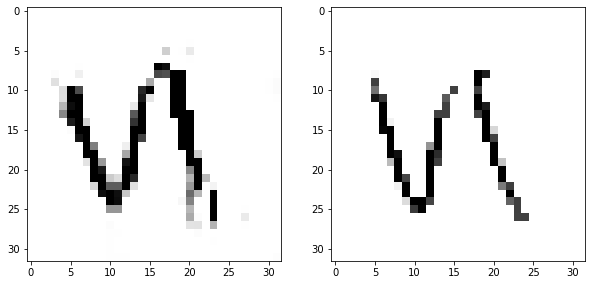

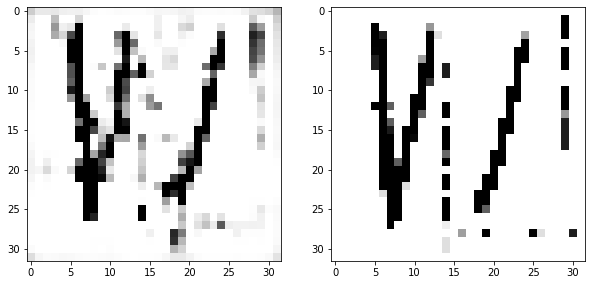

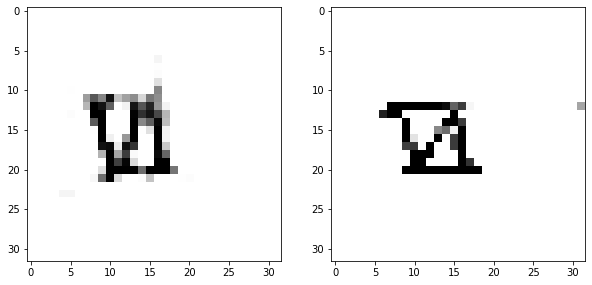

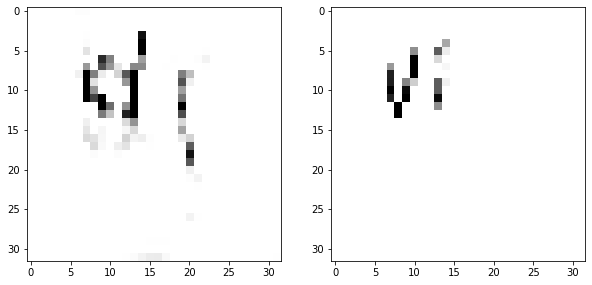

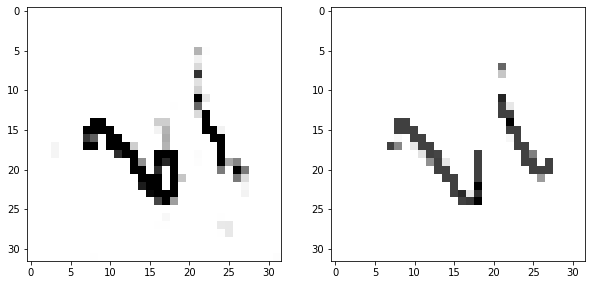

In [16]:
for i in range(20):
    fig = plt.figure(figsize=(10, 5))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    image = out[i]
    image = Image.fromarray(image)
    enhancer = ImageEnhance.Sharpness(image)
    image = enhancer.enhance(10)
    
    ax1.imshow(image, cmap='binary_r')
    ax2.imshow(vae.train_x[i, :, :, 0], cmap='binary_r')

# Synthetic Images

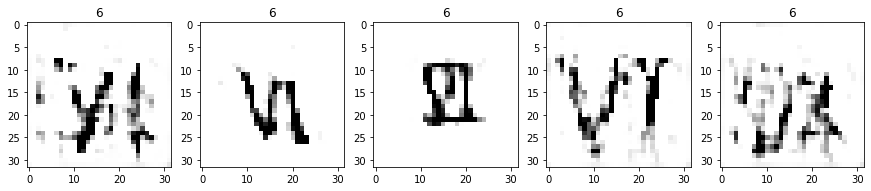

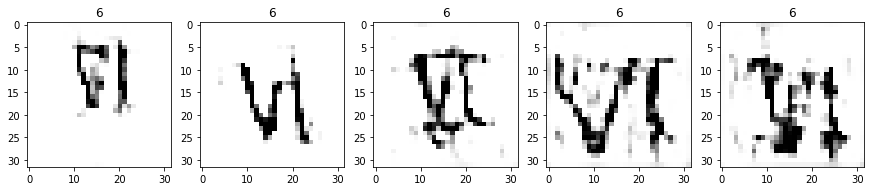

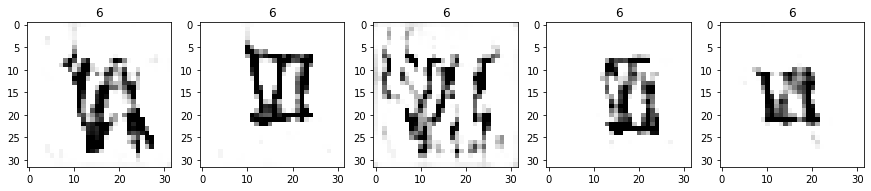

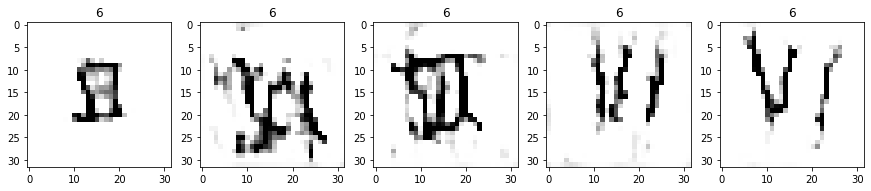

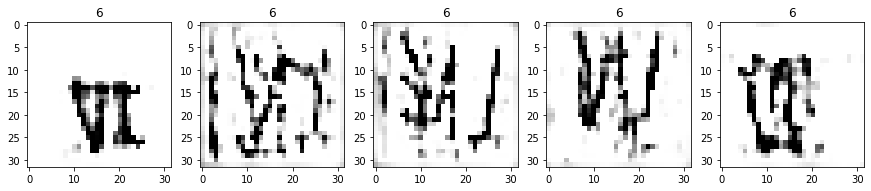

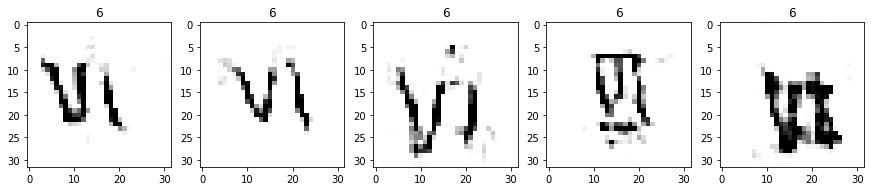

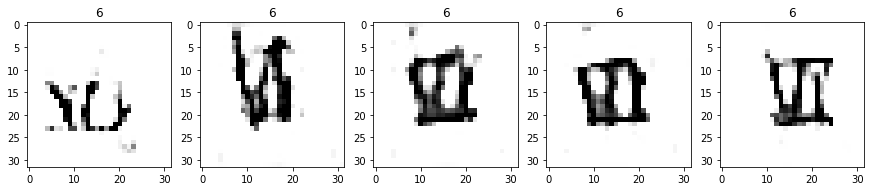

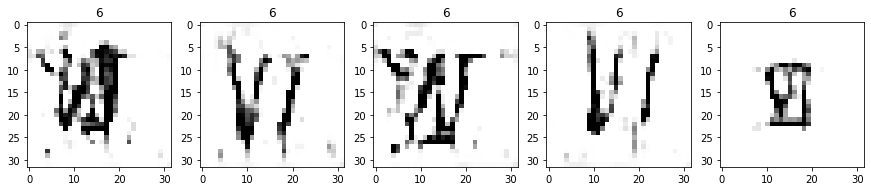

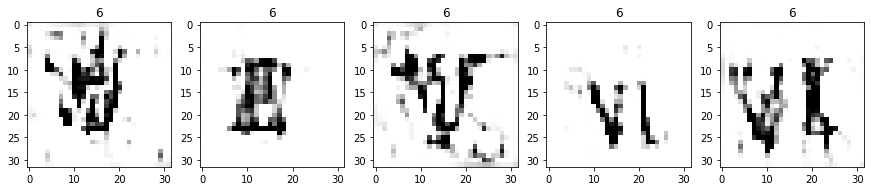

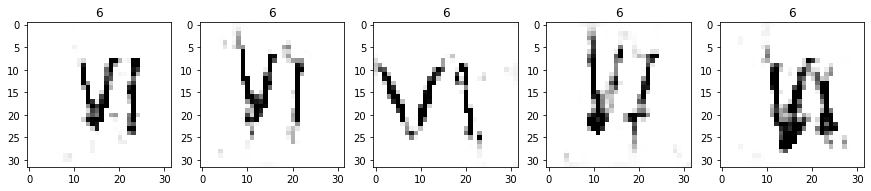

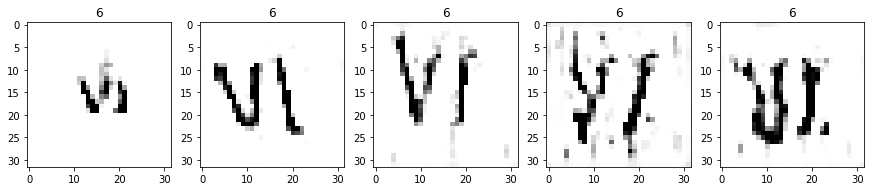

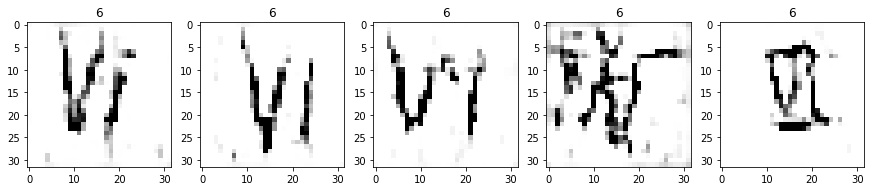

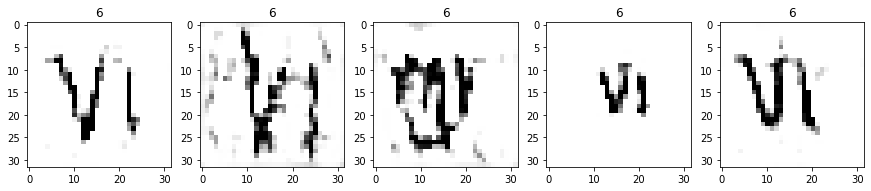

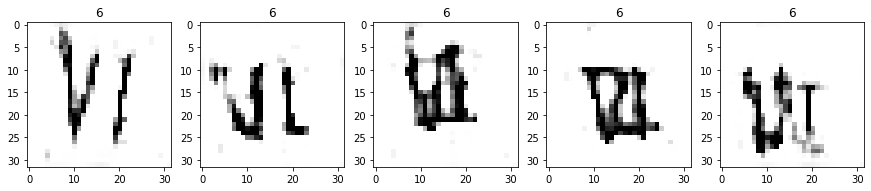

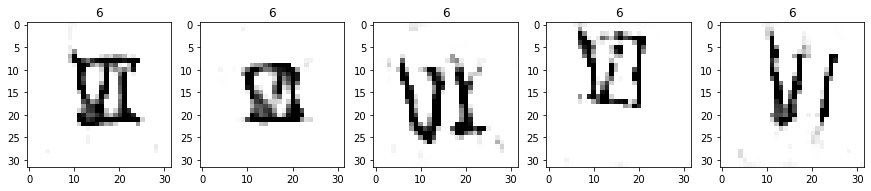

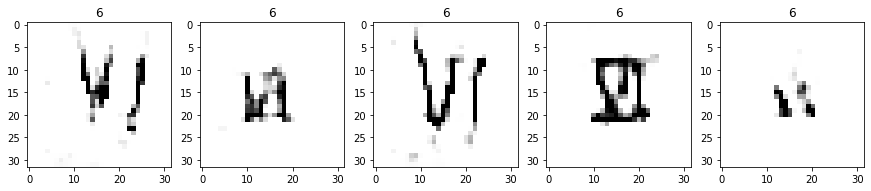

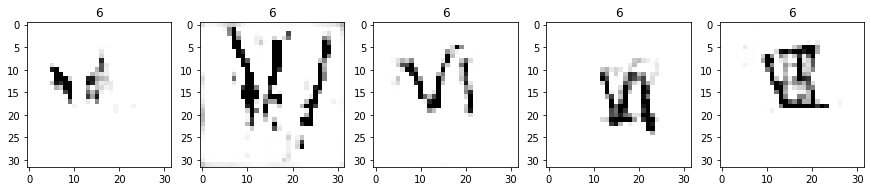

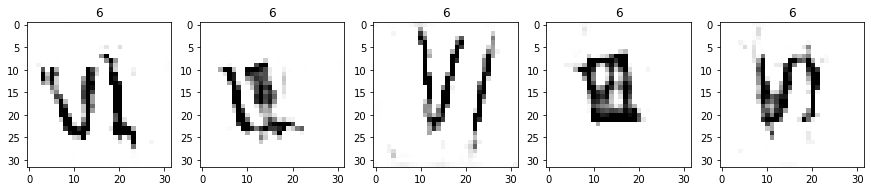

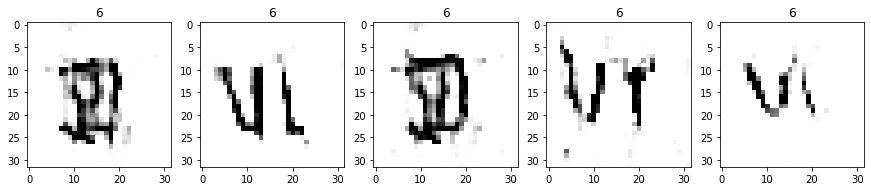

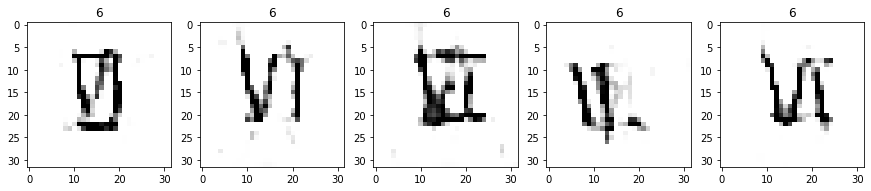

In [21]:
eps = tf.random.normal(shape=(100, vae.latent_dim)) * 0.75

z = vae.encode(images)[0].numpy()
tree = cKDTree(z)
dist, inn = tree.query(eps, k=1)

if len(inn.shape) == 1:
    nn_labels = np.where(labels[inn])[1] + 1
else:
    nn_labels = np.zeros(len(images))
    for i in range(inn.shape[0]):
        nn_labels[i] = mode([np.where(labels[j])[0][0] + 1 for j in inn[i, :].flatten()])

out = vae.sample(eps=eps, standardize=False, numpy=True, apply_sigmoid=True, to_image=True)

for i in range(20):
    fig = plt.figure(figsize=(15, 4))
    ax1 = fig.add_subplot(151)
    ax2 = fig.add_subplot(152)
    ax3 = fig.add_subplot(153)
    ax4 = fig.add_subplot(154)
    ax5 = fig.add_subplot(155)
    for j, ax in enumerate((ax1, ax2, ax3, ax4, ax5)):
        k = i*5+j
        im_eps = eps[k].numpy()
        
        image = Image.fromarray(out[k])
        enhancer = ImageEnhance.Sharpness(image)
        image = enhancer.enhance(10)
        
        ax.imshow(image, cmap='binary_r')
        ax.set_title(nn_labels[k])
    


# Check Loaded Model

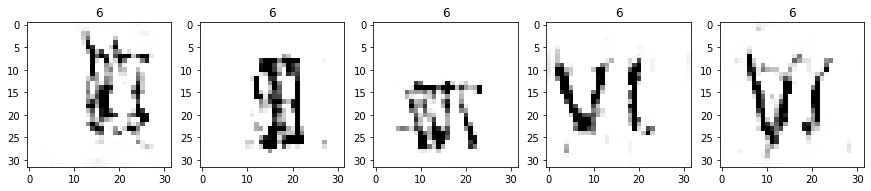

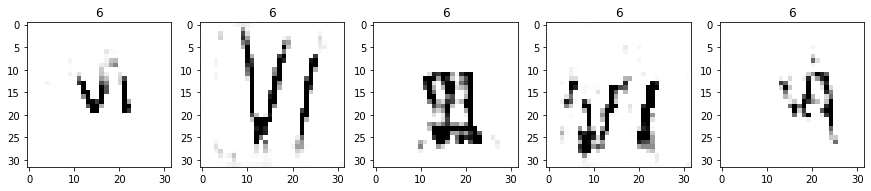

In [18]:
eps = tf.random.normal(shape=(100, loaded.latent_dim))

z = loaded.encode(images)[0].numpy()
tree = cKDTree(z)
dist, inn = tree.query(eps, k=1)

if len(inn.shape) == 1:
    nn_labels = np.where(labels[inn])[1] + 1
else:
    nn_labels = np.zeros(len(images))
    for i in range(inn.shape[0]):
        nn_labels[i] = mode([np.where(labels[j])[0][0] + 1 for j in inn[i, :].flatten()])

out = loaded.sample(eps=eps, standardize=False, numpy=True, apply_sigmoid=True, to_image=True)

for i in range(1):
    fig = plt.figure(figsize=(15, 4))
    ax1 = fig.add_subplot(151)
    ax2 = fig.add_subplot(152)
    ax3 = fig.add_subplot(153)
    ax4 = fig.add_subplot(154)
    ax5 = fig.add_subplot(155)
    for j, ax in enumerate((ax1, ax2, ax3, ax4, ax5)):
        k = i*5+j
        im_eps = eps[k].numpy()
        
        image = Image.fromarray(out[k])
        enhancer = ImageEnhance.Sharpness(image)
        image = enhancer.enhance(10)
        
        ax.imshow(image, cmap='binary_r')
        ax.set_title(nn_labels[k])
    


# Save Models to Data Dir

In [22]:
N = 100

eps = tf.random.normal(shape=(N, vae.latent_dim)) * 0.75
out = vae.sample(eps=eps, standardize=False, numpy=True, apply_sigmoid=True, to_image=True)

out_dir = './data/data/vae_out/{}'.format(numeral)
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

for i in range(N):
    image = Image.fromarray(out[i])
    enhancer = ImageEnhance.Sharpness(image)
    image = enhancer.enhance(10)
    fn = "{}_{}.png".format(numeral, str(i).zfill(4))
    fp_out = os.path.join(out_dir, fn)
    image.save(fp_out)